# Seismic Receiver function example: direct search

An example script to demonstrate use of the receiver function forward code pyrf96 which is based on Fortran code from [Shibutani etal. 1996](https://rses.anu.edu.au/~malcolm/papers/pdf/grl9623.pdf) interfaced to python using ctypes.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/pyrf96/examples/RF_direct_search_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

Receiver functions are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U git+https://github.com/inlab-geo/pyrf96

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyrf96

The function `pyrf96.rfcalc()` computes synthetic receiver functions (using routines developed by Prof. T. Shibutani). It is called as follows:
```python
t,rfunc = pyrf96.rfcalc(model)
```
where `model` is a NumPy array of dimension `[nlayers,3]`. 

#### Model formats
Three input model formats are possible depending on optional parameter `mtype`.


**Voronoi cell mode** (`mtype=0`, default):
In this case `model[:,0]` are the depths of Voronoi cell nuclei, which each define a layer of constant velocity. Here interfaces are defined implicitely as the mid-points between successive nuclei. For example, the interface at the base of the first layer lies at depth `0.5*[model[0,0]+model(1,0)]`
The S-wave speeds for each layer are given by  `model[:,1]`, and `model[:,2]` are the ratio of P-wave speed to S-wave speed in each layer. This format is convenient as a parameterization for optimization, or Bayesian sampling, since nuclei are independent and can be unordered. See Figure 1 of [Bodin et al. 2012](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011JB008560).

**Layer thickness mode** (`mtype=1`):
In this case  `model[:,0]` are the thicknesses of each layer. Here interfaces are defined implicitely as the sum of successive thicknesses. For example, the interface at the base of the second layer lies at depth `model[0,0]+model(1,0)`. The S-wave speeds for each layer are given by  `model[:,1]`, and `model[:,2]` are the ratio of P-wave speed to S-wave speed in each layer.

**Interface depth mode** (`mtype=2`):
In this case the values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of P-wave speed to S-wave speed. The maximum depth of discontinuity that can be considered is 60km.

For full details see the docstring `help(pyrf96.rfcalc)` 

For example, here is the Earth model in interface depth mode (`mtype=2`).

In [3]:
model = np.array([[1,4.0,1.7],
                  [3.5,4.3,1.7],
                  [8.0,4.2,2.0],
                  [20, 6,1.7],
                  [45,6.2,1.7]])

Lets plot the Earth model

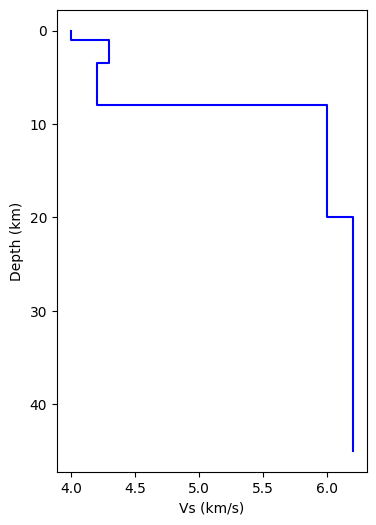

In [4]:
px = np.zeros([2*len(model),2])
py = np.zeros([2*len(model),2])
n=len(model)
px[0::2,0],px[1::2,0],px[1::2,1],px[2::2,1] = model[:,1],model[:,1],model[:,0],model[:-1,0]
plt.figure(figsize=(4,6))
plt.xlabel('Vs (km/s)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()
plt.plot(px[:,0],px[:,1],'b-')
plt.show()

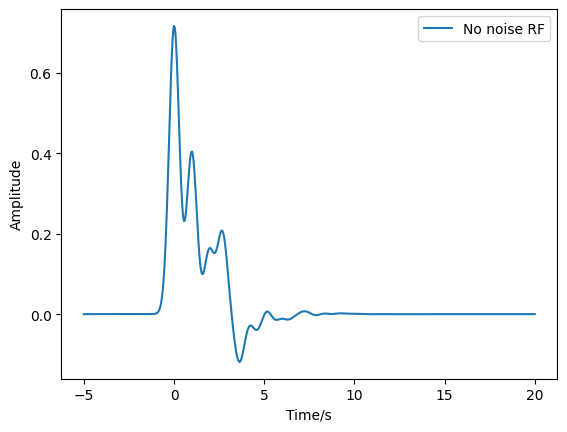

In [5]:
# calculate and plot receiver function together 
t,RFp = pyrf96.rfcalc(model,mtype=2)          # Receiver function
plt.plot(t,RFp,label='No noise RF')
plt.xlabel('Time/s')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### Adding noise to the Receiver function

It can be useful to add synthetic noise to a receover function to test inversion methods. We have two ways of adding synthetic noise to a receiver function.

**Frequency domain** - Here the frequency characteristics of the noise are constrained to be similar to the noiseless receiver function. A single parameter which controls the amplitude of the noise may be set with the parameter `sn=...` in the calling sequence. The higher the value the larger the noise amplitude. 

**Time domain** - Here a correlated noise time signal is added to the noiseless receiver function. This is implemented through a dictionary called `noise={}`. The user can specify the amplitude standard deviation `noise["amp_sigma"]`; the time correlation in seconds `noise["corr_time"]`; and the noise covariance function  `noise["kernel"]` with choices of `"sqExp","matern0","matern1","matern2","periodic"`.

Here we calculate a noiseless and noisy receiver function with noise generated in the frequency domain.

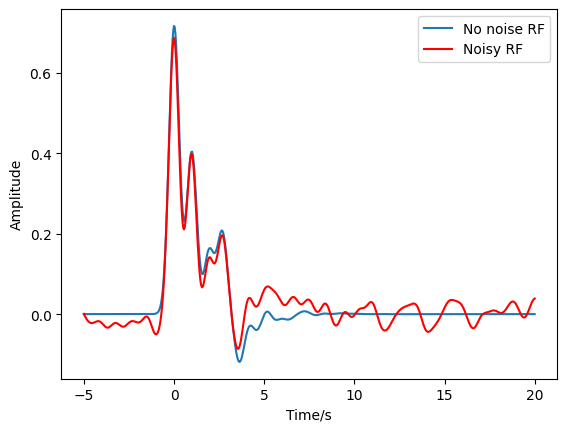

In [6]:
# calculate and plot receiver function together with noisy receiver function 
t,RFp = pyrf96.rfcalc(model,mtype=2)          # Receiver function
t2,RFo = pyrf96.rfcalc(model,sn=0.3,seed=12345678,mtype=2) # Receiver function with added correlated noise in teh frequency domain
plt.plot(t,RFp,label='No noise RF')
plt.plot(t2,RFo,'r-',label='Noisy RF')
plt.xlabel('Time/s')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Here generate Gaussian correlated noise in the time domain.

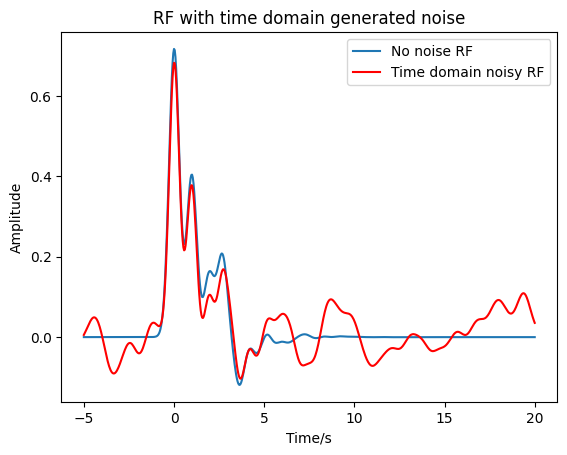

In [7]:
# Set up a noise model in time domain
noise = {}
noise['kernel'] = 'sqExp'  # Kernel time sqExp = Gaussian
noise['amp_sigma'] = 0.04  # Amplitude standard deviation (in amplitude units)
noise['corr_time'] = 0.5   # Time correlation (in seconds)

# calculate and plot receiver function with different parameters
t,rfunc = pyrf96.rfcalc(model,mtype=2)          # Receiver function
t2,rfunc2,Cd = pyrf96.rfcalc(model,seed=12345678,mtype=2,noise=noise) # Receiver function with added correlated noise
plt.title('RF with time domain generated noise')
plt.plot(t,rfunc,label='No noise RF')
plt.plot(t2,rfunc2,'r-',label='Time domain noisy RF')
plt.xlabel('Time/s')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

This routine also returns the covariance matrix of the noise, which can be useful if a Likelihood function isto be constructed.

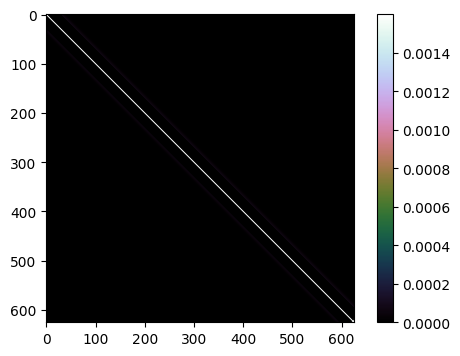

In [8]:
plt.figure(figsize=(6,4))
plt.imshow(Cd,cmap=plt.cm.cubehelix)
plt.colorbar()
plt.contour(Cd,10,colors='k')
plt.show()

**Task 1:** Familiarise yourself with the function `pyrf96.rfcalc()` and explore how the receiver function behaves as you change the model.

Here is an example of using the Voronoi nuclei model format (`mtype=0`).

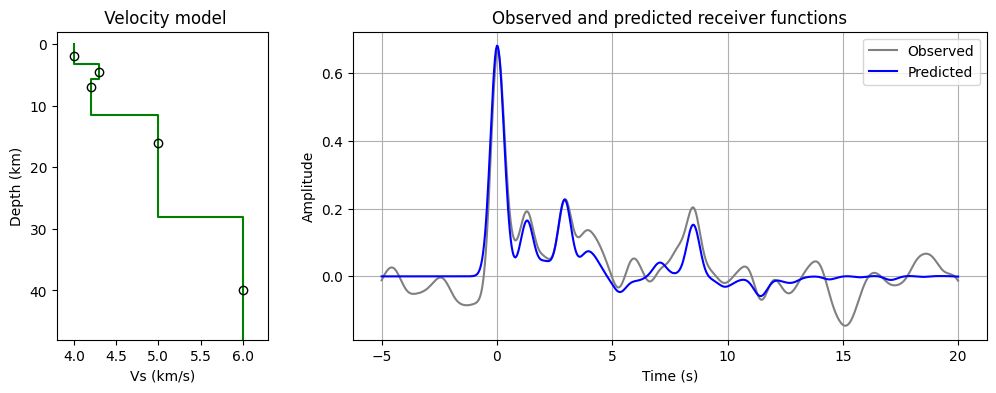

In [9]:
# generate new Earth model using Voronoi format and plot it with receiver function
model = np.array([[2,4.0,1.7],
                  [4.5,4.3,1.7],
                  [7.0,4.2,2.0],
                  [16, 5,1.7],
                  [40,6.,1.7]])
time1,RFo,Cd = pyrf96.rfcalc(model,noise=noise)          # Calculate noisy Receiver function (time domain noise)
time2,RFp = pyrf96.rfcalc(model) # Calculate predicted noiseless Receiver function

# plot RF together with noise 
a,b, = pyrf96.plotRFm(model,time1,RFo,time2,RFp,
    vmin=3.8,
    vmax=6.3,
    dmin=-2.0,
    dmax=48.0,
    plotnuclei=True,
    title="Observed and predicted receiver functions")

**Task 2:** Invent a model with around 5 layers, plot it and then compute the corresponding receiver function with the noise parameter `sn` set to some reasonable value, say `sn=0.5`. Plot the noisy and noiseless receiver functions together just as in the figure above. We are going to treat the noisy receiver function as data.

To measure the fit of this observed receiver function to the receiver function predicted by any other model, ${\mathbf d}_{pred}$, we need to compute the negative log of the Likelihood

\begin{equation*}
-\log (p({\mathbf d}_{obs} | {\mathbf m}) = ({\mathbf d}_{obs}-{\mathbf d}_{pred})^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred})
\end{equation*}

where $C_D^{-1}$ is the inverse data covariance matrix describing correlated noise in the receiver function. 

For time domain generated noise you can do this using the supplied routine InvDataCov($\sigma_t$,$\sigma_a$,$n$), which builds an $n\times n$ inverse data covariance matrix for a time signal with amplitude variance $\sigma_a^2$ and time correlation length $\sigma_t$ (in units of time steps) for receiver length of $n$ time samples. 

For noise generated in the frequency domian use $\sigma_t = 2.5$, $\sigma_a=0.01$. For noise generated in the time domain you can use the data covariance matrix returned the `rfunc()` routine.

Compute the negative log Likelihood between the noisy data and the predicted receiver function of the true model. 

In [10]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

#Cdinv = pyrf96.InvDataCov(2.5,0.01,len(rfunc)) # This is the inverse data covariance for the noisy receiver function
Cdinv = np.linalg.inv(Cd)                      # This is the inverse data covariance for the noisy receiver function with noise (generated in the time domain)

# now compute the negative log Likelihood between the receiver functions of your two models.
res = RFo-RFp
mref = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
print (' Waveform misfit of reference model',mref)

 Waveform misfit of reference model 70.39207744123269


**Task 3:** Now we're going to assume that we know everything about the model, except for the depth of one interface. Select one interface in your model which you will pretend is 'unknown', and plot how the agreement between 'data' and synthetics varies with this unknown. Choose ranges for each variable something like the following $(0,60)$ km for a depth variable. Try and plot the negative log-Likelihood as a function of the depth variable. Is the minimum where you expected it to be? Does your plot give you the impression that this problem is highly nonlinear?

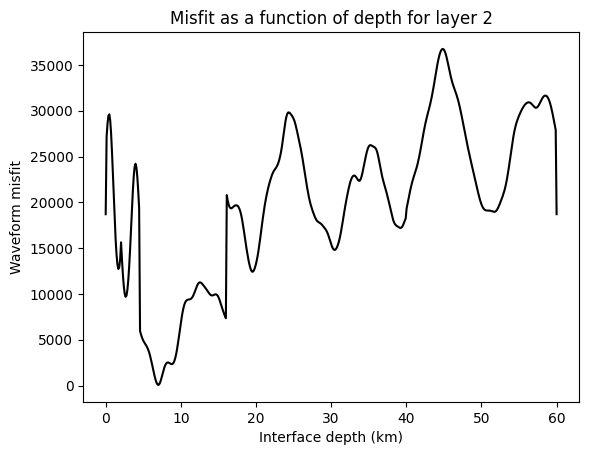

 Minimum misfit at depth  6.973947895791583  with true value at  7.0


In [11]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Calculate misfit as a function of depth of a chosen layer

depths = np.linspace(0.,60.,500) # depth samples
iface = 2 # index of interface
misfit = np.zeros(len(depths))
for i,d in enumerate(depths):
    m = np.copy(model)
    m[iface,0] = d
    time,RFpm = pyrf96.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
    res = RFo-RFpm
    misfit[i] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit profile
plt.title('Misfit as a function of depth for layer '+repr(iface))
plt.plot(depths,misfit,'k-')
plt.xlabel('Interface depth (km)')
plt.ylabel('Waveform misfit')
plt.show()
print(' Minimum misfit at depth ',depths[np.argmin(misfit)],' with true value at ',model[iface,0])


**Task 4:** Explore what happens if the unknown parameter is $V_s$ in the layer, or its $V_p/V_s$ ratio, and its depth is known. Choose ranges for each variable something like $\pm 1.0 km/s$ for a $V_s$ variable or $\pm 0.5$ for $/V_s/V_p$. 

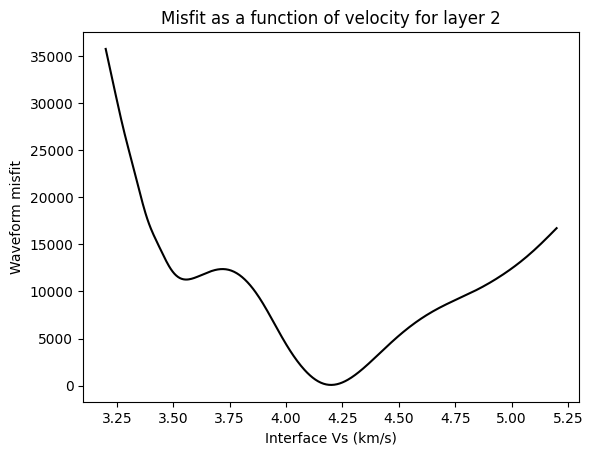

 Minimum misfit at velocity  4.197995991983968  with true value at  4.2


In [12]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Calculate misfit as a function of shear velocity of a chosen layer

iface = 2 # index of interface
Vs = np.linspace(model[iface,1]-1.0,model[iface,1]+1.0,500) # Vs samples
misfit = np.zeros(len(Vs))
for i,x in enumerate(Vs):
    m = np.copy(model)
    m[iface,1] = x
    time,RFpm = pyrf96.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
    res = RFo-RFpm
    misfit[i] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit profile
plt.title('Misfit as a function of velocity for layer '+repr(iface))
plt.plot(Vs,misfit,'k-')
plt.xlabel('Interface Vs (km/s)')
plt.ylabel('Waveform misfit')
plt.show()
print(' Minimum misfit at velocity ',Vs[np.argmin(misfit)],' with true value at ',model[iface,1])


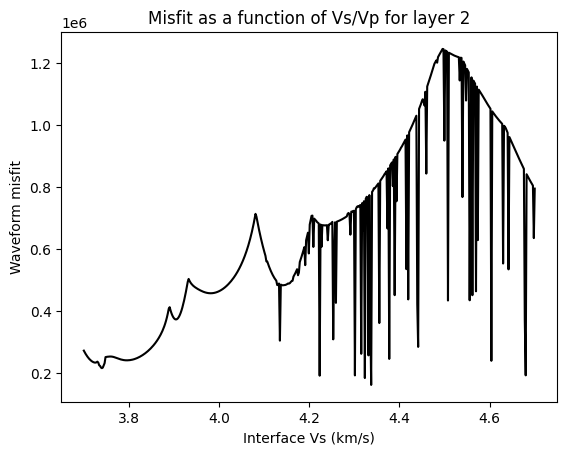

 Minimum misfit at Vs/Vp  4.337274549098197  with true value at  2.0


In [13]:

#Calculate misfit as a function of Vs/Vp ratio of a chosen layer

iface = 2 # index of interface
VsVp = np.linspace(model[iface,1]-0.5,model[iface,1]+0.5,500) # depth samples
misfit = np.zeros(len(Vs))
for i,x in enumerate(Vs):
    m = np.copy(model)
    m[iface,2] = x
    time,RFpm = pyrf96.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
    res = RFo-RFpm
    misfit[i] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit profile
plt.title('Misfit as a function of Vs/Vp for layer '+repr(iface))
plt.plot(VsVp,misfit,'k-')
plt.xlabel('Interface Vs (km/s)')
plt.ylabel('Waveform misfit')
plt.show()
print(' Minimum misfit at Vs/Vp ',VsVp[np.argmin(misfit)],' with true value at ',model[iface,2])


**Task 5:** Now, suppose we have two unknown parameters - the interface depth and associated $V_s$, perhaps, or two depth parameters. Map out how the agreement between 'data' and predicted receiver function varies as you change both parameters. Plot a contour map of this data misfit surface? How multi-modal is this?

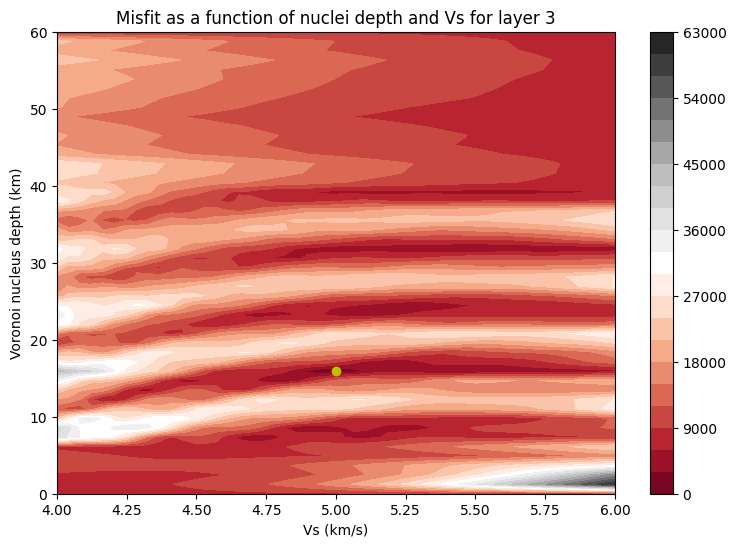

 Minimum misfit at depth  15.918367346938776  with true value at  16.0
 Minimum misfit at velocity  4.979591836734694  with true value at  5.0


In [14]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Calculate misfit as a function of depth of a chosen layer

iface = 3 # index of interface
depths = np.linspace(0.,60.,50) # depth samples
Vs = np.linspace(model[iface,1]-1.0,model[iface,1]+1.0,50) # Vs samples
misfit = np.zeros((len(depths),len(Vs)))
for i,d in enumerate(depths):
    for j,v in enumerate(Vs):
        m = np.copy(model)
        m[iface,0] = d
        m[iface,1] = v
        time,RFpm = pyrf96.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
        res = RFo-RFpm
        misfit[i,j] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit contours
fig = plt.figure(figsize=(9,6))
plt.title('Misfit as a function of nuclei depth and Vs for layer '+repr(iface))
#plt.plot(depths,misfit,'k-')
plt.ylabel('Voronoi nucleus depth (km)')
plt.xlabel('Vs (km/s)')
X, Y = np.meshgrid(Vs, depths)
plt.contourf(X, Y, misfit, 20, cmap='RdGy')
plt.plot(model[iface,1],model[iface,0],'yo')
plt.colorbar()
plt.show()
ix,jx = np.unravel_index(misfit.argmin(), misfit.shape) # location of misfit minimum
print(' Minimum misfit at depth ',depths[ix],' with true value at ',model[iface,0])
print(' Minimum misfit at velocity ',Vs[jx],' with true value at ',model[iface,1])


**Task 6:** Now choose to search this 2-D space with either a (nested) grid search in a square or a (nested) Gaussian sampler. In each case you must choose the density of the sampling, adjust the centre of the sampling in each iteration and record the progress toward finding the best fit solution. How close do you get to the known true values? How does the distance between the best fit solution and the true solution change with numbers of random samples? Try and plot this.

 Lowest misfit solution found after  0  iterations of Gaussian cloud  [ 4.5 20. ]
 Lowest misfit solution found after  1  iterations of Gaussian cloud  [ 4.93355816 16.08017439]
 Lowest misfit solution found after  2  iterations of Gaussian cloud  [ 5.46269025 16.10375754]
 Lowest misfit solution found after  3  iterations of Gaussian cloud  [ 5.10719034 16.47343105]
 Lowest misfit solution found after  4  iterations of Gaussian cloud  [ 4.9798792  16.13948309]


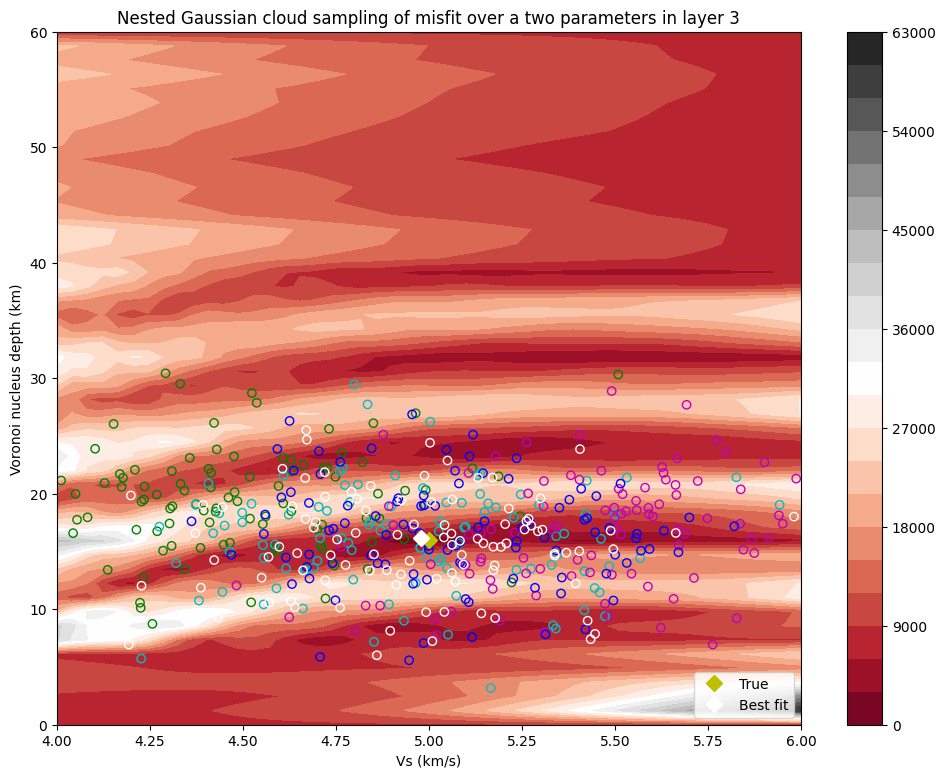

 True solution is 5.0 16.0


In [15]:
nits = 5 # number of nested iterations
nump = 100 # number of points per iteration
cov = [[0.1,0],[0,20]] # Covariance for Gaussian samples
p = np.array([])
allp = [0]*nits
bp = [0]*(nits+1)
bp[0] = np.array([4.5,20]) # starting point for Gaussian cloud matters
#bp[0] = np.array([4.5,40]) # starting point for Gaussian cloud matters
mis0 = 1e6
for it in range(nits):
    p0 = np.random.multivariate_normal(bp[it], cov,nump)
    bp[it+1] = bp[it]
    for i,x in enumerate(p0):
        if(x[1]<=depths[-1] and x[1] >= depths[0] and x[0]<=Vs[-1] and x[0] >= Vs[0]):
            p=np.append(p,[x[0],x[1]])
            m = np.copy(model)
            m[iface,0] = x[1]
            m[iface,1] = x[0]
            time,RFpm = pyrf96.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
            res = RFo-RFpm
            mis = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
            if(mis < mis0):
                mis0 = np.copy(mis)
                bp[it+1] = np.copy(x)
    allp[it] = np.reshape(p,(-1,2))
    p = np.array([])

fig = plt.figure(figsize=(12,9))
plt.title('Nested Gaussian cloud sampling of misfit over a two parameters in layer '+repr(iface))
#plt.plot(depths,misfit,'k-')
plt.ylabel('Voronoi nucleus depth (km)')
plt.xlabel('Vs (km/s)')
X, Y = np.meshgrid(Vs, depths)
plt.contourf(X, Y, misfit, 20, cmap='RdGy')
plt.plot(model[iface,1],model[iface,0],'yo')
plt.colorbar()
c = ['g','c','m','b','w']
for i in range(nits):
    plt.scatter(allp[i].T[0], allp[i].T[1], facecolors='none',edgecolors=c[i],alpha=1.0)
    #plt.plot(bp[i].T[0],bp[i].T[1],'o',color=c[i])
    print(' Lowest misfit solution found after ',i,' iterations of Gaussian cloud ',bp[i])
#plt.plot(bp[i].T[0],bp[i].T[1],'wo',markersize=3.0)
plt.plot(model[iface,1],model[iface,0],'yD',markersize=8.0,label='True')
plt.plot(bp[i].T[0],bp[i].T[1],'wD',markersize=8.0,lw=1.0,label='Best fit')
plt.legend(loc=4)
plt.show()
print(' True solution is',model[iface,1],model[iface,0])


**Gaussian nested sampling convergence to a reasonable solution**

The true solution is at $V_s=5.0$ km/s and $z=16.0$ km, whereas the nested Gaussain cloud converges to $V_s=5.05$ km/s and $z=16.22$ km.

**Task 7:** What happens when you repeat this process and start from a different point. Try several and see if you always get a solution? Are there starting points where it does not converge?

**Gaussian nested sampling**

This result shows the convergence of a random Gaussian cloud of 100 points initially centred on the location $V_s =4.5$ km/s and $z = 45$ km. Five iterations are shown where the mean of the Gaussian samples is shifted to the best fit of the previous iteration. It gradually converges to the misfit minimum of this 2D slice. The lowest misfit found solution is the white circle and the true solution is the yellow circle.

#### A second try with a further away starting centre of the Gaussian cloud

 Lowest misfit solution found after  0  iterations of Gaussian cloud  [ 4.5 45. ]
 Lowest misfit solution found after  1  iterations of Gaussian cloud  [ 4.75075345 38.90391199]
 Lowest misfit solution found after  2  iterations of Gaussian cloud  [ 5.19020881 39.30563931]
 Lowest misfit solution found after  3  iterations of Gaussian cloud  [ 5.04087918 32.03103715]
 Lowest misfit solution found after  4  iterations of Gaussian cloud  [ 5.27704951 31.91349556]


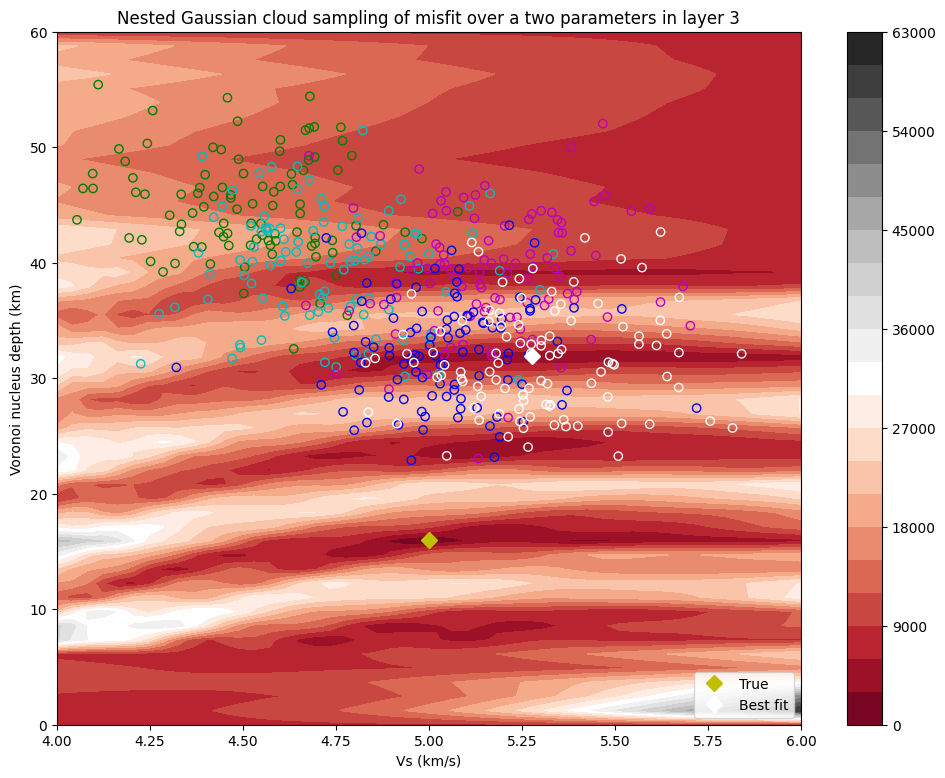

 True solution is 5.0 16.0


In [16]:
nits = 5 # number of nested iterations
nump = 100 # number of points per iteration
cov = [[0.05,0],[0,20]] # Covariance for Gaussian samples
p = np.array([])
allp = [0]*nits
bp = [0]*(nits+1)
bp[0] = np.array([4.5,45]) # starting point for Gaussian cloud matters
mis0 = 1e6
for it in range(nits):
    p0 = np.random.multivariate_normal(bp[it], cov,nump)
    bp[it+1] = bp[it]
    for i,x in enumerate(p0):
        if(x[1]<=depths[-1] and x[1] >= depths[0] and x[0]<=Vs[-1] and x[0] >= Vs[0]):
            p=np.append(p,[x[0],x[1]])
            m = np.copy(model)
            m[iface,0] = x[1]
            m[iface,1] = x[0]
            time,RFpm = pyrf96.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
            res = RFo-RFpm
            mis = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
            if(mis < mis0):
                mis0 = np.copy(mis)
                bp[it+1] = np.copy(x)
    allp[it] = np.reshape(p,(-1,2))
    p = np.array([])

fig = plt.figure(figsize=(12,9))
plt.title('Nested Gaussian cloud sampling of misfit over a two parameters in layer '+repr(iface))
#plt.plot(depths,misfit,'k-')
plt.ylabel('Voronoi nucleus depth (km)')
plt.xlabel('Vs (km/s)')
X, Y = np.meshgrid(Vs, depths)
plt.contourf(X, Y, misfit, 20, cmap='RdGy')
plt.plot(model[iface,1],model[iface,0],'yo')
plt.colorbar()
c = ['g','c','m','b','w']
for i in range(nits):
    plt.scatter(allp[i].T[0], allp[i].T[1], facecolors='none',edgecolors=c[i],alpha=1.0)
    #plt.plot(bp[i].T[0],bp[i].T[1],'o',color=c[i])
    print(' Lowest misfit solution found after ',i,' iterations of Gaussian cloud ',bp[i])
#plt.plot(bp[i].T[0],bp[i].T[1],'wo',markersize=3.0)
plt.plot(model[iface,1],model[iface,0],'yD',markersize=8.0,label='True')
plt.plot(bp[i].T[0],bp[i].T[1],'wD',markersize=8.0,lw=1.0,label='Best fit')
plt.legend(loc=4)
plt.show()
print(' True solution is',model[iface,1],model[iface,0])


**Gaussian nested sampling convergence to a secondary minimum**
This result shows the convergence of a random Gaussian cloud of 100 points initially centred on the location $V_s =4.5$ km/s and $z = 45$ km. Five iterations are shown where the mean of the Gaussian samples is shifted to the best fit of the previous iteration. It gradually converges to a secondary minimum of this 2D slice and **not** the true global minimum. The lowest misfit found solution is the white circle and the true solution is the yellow circle.

----